### Resources
1. Data: https://www.kaggle.com/datasets/jeetblahiri/bccd-dataset-with-mask/data
   * Stored in: ```../data/bccd-dataset-with-mask/```
3. Model: UNI
    * Model available: https://huggingface.co/MahmoodLab/UNI

In [ ]:
# Skip this section if running code locally
from google.colab import drive
drive.mount('/content/drive') # Data: /content/drive/MyDrive/DL_cell_segmentation/data


Mounted at /content/drive


In [14]:
# Load other modules
import sys
import os
# import kagglehub
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from torchvision import io

import warnings
warnings.filterwarnings("ignore") # Silence warning


# 1. Download data

## 1.1 Download data and check
Moved to: ```DL/UNI_assginment/data/bccd-dataset-with-mask```

In [ ]:
# # Download latest version
# path = kagglehub.dataset_download("jeetblahiri/bccd-dataset-with-mask")

# print("Path to dataset files:", path)

/content/drive/MyDrive/DL_cell_segmentation/data/train/mask/002f20ad-2ace-499c-9335-c9080bc3e6b5.png


Text(0.5, 1.0, 'Mask')

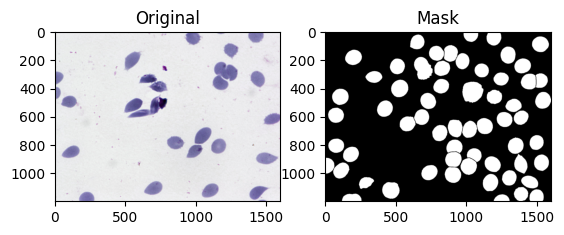

In [ ]:
# Check images
root_dir = '/content/drive/MyDrive/DL_cell_segmentation'

train_images = glob.glob(f'{root_dir}/data/train/original/*.png')
train_masks = glob.glob(f'{root_dir}/data/train/mask/*.png')

test_images = glob.glob(f'{root_dir}/data/test/original/*.png')
test_masks = glob.glob(f'{root_dir}/data/test/mask/*.png')

train_images.sort()
train_masks.sort()

test_images.sort()
test_masks.sort()

print(train_masks[0]), str(train_images[0])

# Display original image and mask
image_idx = 10

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(mpimg.imread(train_images[0]))
ax[0].set_title('Original')
ax[1].imshow(mpimg.imread(train_masks[0]))
ax[1].set_title('Mask')


## 1.2 Preprocess images

### (1) Stain nomalization (Macenko normalization)
Reference: https://www.geeksforgeeks.org/machine-learning/macenko-method-for-normalizing-histology-slides-for-quantitative-analysis/#implementation-of-macenko-method-in-python

In [ ]:
# Insallation of this library might encounter issue in colab
# But worked locally
# ! pip install tiatoolbox

In [ ]:
# Import modules required to run the Jupyter notebook
from __future__ import annotations

# Clear logger to use tiatoolbox.logger
import logging

if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()

from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
import skimage.color

from tiatoolbox import data, logger
from tiatoolbox.tools import stainnorm
from tiatoolbox.wsicore import wsireader
import cv2
# mpl.rcParams["figure.dpi"] = 150  # for high resolution figure in notebook


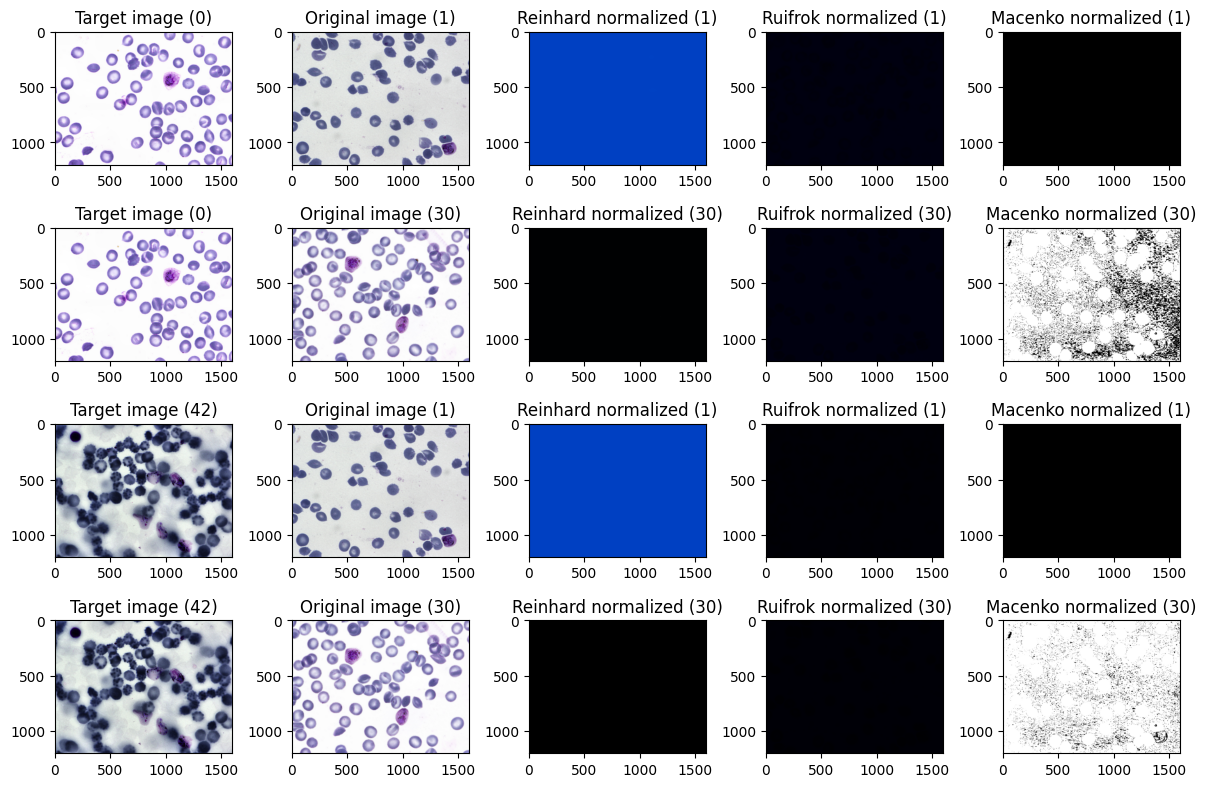

In [ ]:
# The images are in BGR color if opened with CV2, need to convert to RGB

# Set the 1st image in training set to be target image

fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12,8))
ax = ax.flatten()

method_name_list = ["Reinhard", "Ruifrok", "Macenko"] # "Vahadane" encounter issues about SVD did not converge
offset = 0
for target_img_indx in [0, 42]: # Randomly check two target images
    for img_indx in [1, 30]: # Test different normalization method on different images
        target_image = mpimg.imread(train_images[target_img_indx])

        ax[0+offset].imshow(target_image)
        ax[0+offset].set_title(f'Target image ({target_img_indx})')

        ax[1+offset].imshow(sample)
        ax[1+offset].set_title(f'Original image ({img_indx})')

        for i, method_name in enumerate(method_name_list):
            stain_normalizer = stainnorm.get_normalizer(method_name=method_name)
            stain_normalizer.fit(target_image)

            # Stain norm the image
            sample = mpimg.imread(train_images[img_indx])
            # sample_rgb = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
            # sample = mpimg.imread('/Users/wanying/Downloads/44c69d56a857f498a1b4f8ee71be547312e844e1fd37f802460f47c79b610fb7.webp')
            normed_sample = stain_normalizer.transform(sample.copy())
            ax[i+2+offset].imshow(normed_sample)
            ax[i+2+offset].set_title(f'{method_name} normalized ({img_indx})')
        offset += 5
fig.tight_layout()
fig.savefig('../plots/01_stain_norm.png')

In [ ]:
sample.shape

(1200, 1600, 3)

In [ ]:
# Patch extraction



# Augmentation strategies

'1.26.4'

# 2. Create and train ViT-B + mask R-CNN model
* Use Huggingface version of ViT-B and mask RCNN
* Model and training/testing code are saved in ```vitb_maskrcnn.train_test.py```

In [ ]:
# Need to install in colab
! pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 55.7 MB/s eta 0:00:00


In [ ]:

# Use colab GPU
# ep20.config
! root_dir=/content/drive/MyDrive/DL_cell_segmentation; python ${root_dir}/code/vitb_maskrcnn.train_test.py ${root_dir}/config/ep10.config


?
Using device: cuda
loading annotations into memory...
Done (t=0.43s)
creating index...
index created!
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
FPN levels and shapes: {'0': torch.Size([1, 256, 200, 200]), '1': torch.Size([1, 256, 100, 100]), '2': torch.Size([1, 256, 50, 50]), '3': torch.Size([1, 256, 25, 25])}
Train 1/10: 100% 52/52 [02:16<00:00,  2.63s/it]
# Epoch 1: train_loss=1.5251  val_loss=1.0724
Train 2/10: 100% 52/52 [02:31<00:00,  2.91s/it]
# Epoch 2: train_loss=0.9223  val_loss=0.8647
Train 3/10: 100% 52/52 [02:32<00:00,  2.93s/it]
# Epoch 3: train_loss=0.7700  val_loss=0.7823
Train 4/10: 100% 52/52 [02:29<00:00,  2.87s/it]
# Epoch 4: train_loss=0.7046  val_loss=0.6841
Train 5/10: 100% 52/52 [02:30<00:00,  2.89s/it]
# Epoch 5: train_loss=0.6561  val_loss=0.6694
Train 6/1

In [32]:

# ep20, lr=1e-3
! root_dir=/content/drive/MyDrive/DL_cell_segmentation; python ${root_dir}/code/vitb_maskrcnn.train_test.py ${root_dir}/config/ep20.config


?
Using device: cuda
loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
FPN levels and shapes: {'0': torch.Size([1, 256, 200, 200]), '1': torch.Size([1, 256, 100, 100]), '2': torch.Size([1, 256, 50, 50]), '3': torch.Size([1, 256, 25, 25])}
Train 1/20: 100% 52/52 [02:16<00:00,  2.62s/it]
# Epoch 1: train_loss=6.9546  val_loss=1.3202
Train 2/20: 100% 52/52 [02:31<00:00,  2.92s/it]
# Epoch 2: train_loss=1.0192  val_loss=0.9603
Train 3/20: 100% 52/52 [02:27<00:00,  2.83s/it]
# Epoch 3: train_loss=0.8074  val_loss=0.7143
Train 4/20: 100% 52/52 [02:27<00:00,  2.84s/it]
# Epoch 4: train_loss=0.6677  val_loss=0.6727
Train 5/20: 100% 52/52 [02:32<00:00,  2.93s/it]
# Epoch 5: train_loss=0.6953  val_loss=0.7877
Train 6/2

# 3. Data visualization

## 3.1 Plot loss in training and validation sets

In [34]:
loss_fn = '/content/drive/MyDrive/DL_cell_segmentation/outputs/loss_ep20.txt'
df_loss = pd.read_csv(loss_fn, sep='\t')
df_loss.head(10)

,epoch,train_avg,val_avg
0,1,6.9546,1.3202
1,2,1.0192,0.9603
2,3,0.8074,0.7143
3,4,0.6677,0.6727
4,5,0.6953,0.7877
5,6,0.6494,0.6001
6,7,0.5964,0.5928
7,8,0.5702,0.5834
8,9,0.5489,0.5621
9,10,0.5447,0.5610


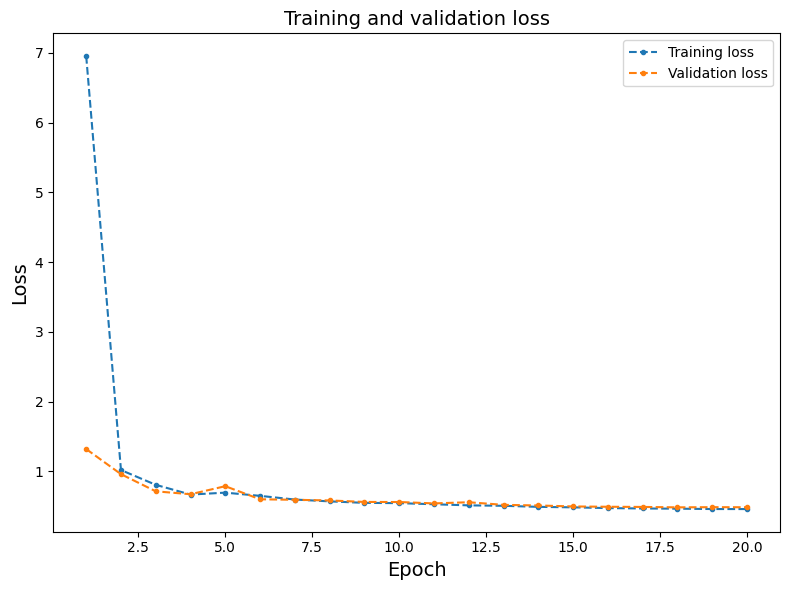

In [37]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df_loss['epoch'], df_loss['train_avg'], marker='.', ls='--', label='Training loss')
ax.plot(df_loss['epoch'], df_loss['val_avg'], marker='.', ls='--', label='Validation loss')
ax.set_title('Training and validation loss', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend()
fig.tight_layout()

## 3.2 Plot evaluation metrics on test set (mAP, IoU, Dice)

In [40]:
eval_fn = '/content/drive/MyDrive/DL_cell_segmentation/outputs/eval_ep20.txt'
df_eval = pd.read_csv(eval_fn, sep='\t')
df_eval.head(20)

,epoch,IoU,mAP,Dice
0,1,0.7918,0.5016,1.0
1,2,0.8316,0.6455,1.0
2,3,0.7657,0.7098,1.0
3,4,0.8590,0.7266,1.0
4,5,0.8561,0.7035,1.0
5,6,0.8572,0.7377,1.0
6,7,0.8594,0.7324,1.0
7,8,0.8649,0.7438,1.0
8,9,0.8694,0.7402,1.0
9,10,0.8580,0.7368,1.0


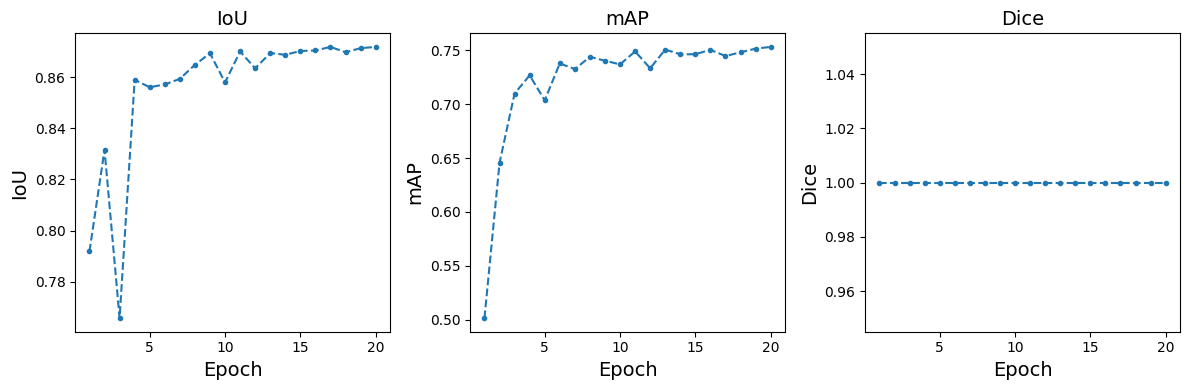

In [39]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4))

for i, metric in enumerate(['IoU', 'mAP', 'Dice']):
    ax[i].plot(df_eval['epoch'], df_eval[metric], marker='.', ls='--')
    ax[i].set_title(metric, fontsize=14)
    ax[i].set_xlabel('Epoch', fontsize=14)
    ax[i].set_ylabel(metric, fontsize=14)
fig.tight_layout()


In [54]:

! root_dir=/content/drive/MyDrive/DL_cell_segmentation; python ${root_dir}/code/vitb_maskrcnn.train_test.py ${root_dir}/config/ep20.config


Using device: cuda
loading annotations into memory...
Done (t=0.43s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.67s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
FPN levels and shapes: {'0': torch.Size([1, 256, 200, 200]), '1': torch.Size([1, 256, 100, 100]), '2': torch.Size([1, 256, 50, 50]), '3': torch.Size([1, 256, 25, 25])}
Train 1/20:   0% 0/52 [00:00<?, ?it/s]####################
{'loss_classifier': tensor(0.6669, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0771, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(3.4545, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.7005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.1297, device='cuda:0', grad_f